**CIFAR -10 CLASSIFICATION** **COURSEWORK**

Here we are setting up a PyTorch data pipeline to load and preprocess the CIFAR-10 dataset for training and testing. It defines transformations to be applied to the data, downloads and loads the dataset using torchvision.datasets.CIFAR10(), and creates batched iterables of the dataset using torch.utils.data.DataLoader(). The pipeline applies random augmentations to the training data, while only normalizing the testing data.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to be applied to the data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


Next, we are  defining a custom PyTorch model called "Model". The model consists of several "Block" modules, each of which contains multiple convolutional layers and a shortcut connection. The "Model" also includes a fully connected classifier at the end. The number of convolutional layers in each block is controlled by the hyperparameter k, which is set to 3 by default. The "Model" is instantiated at the end of the code segment as an object called "custom_model".

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        # Adaptive average pooling layer to reduce spatial dimensions to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
         # Fully connected layer to compute weights for each parallel convolutional layer
        self.fc = nn.Linear(in_channels, k)
         # ModuleList containing k parallel convolutional layers
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, 3, padding=1) for _ in range(k)])
        
           # Shortcut connection to adjust number of channels
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Compute weights for each parallel convolutional layer
        weights = self.fc(self.avg_pool(x).view(b, c))
        weights = F.softmax(weights, dim=1).view(b, -1, 1, 1)

        out = 0
        for i, conv in enumerate(self.convs):
            # Compute weighted output for each parallel convolutional layer
            out += weights[:, i:i + 1] * conv(x)
        
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Model(nn.Module):
    def __init__(self, k=3):
        super(Model, self).__init__()

        # Define the layers of the backbone
        
        layers = [
            (3, 64),
            (64, 128),
            (128, 256),
            (256, 256),
            (256, 512),
            (512, 512)
        ]

        # Create the backbone as a sequential module
        
        self.backbone = nn.Sequential()
        for i, (in_channels, out_channels) in enumerate(layers):
             # Add batch normalization and ReLU activation after each residual block
            if i != 0:
                self.backbone.add_module(f"bn_{i}", nn.BatchNorm2d(in_channels))
                self.backbone.add_module(f"relu_{i}", nn.ReLU(inplace=True))
                if i in [2, 4]:
                    self.backbone.add_module(f"maxpool_{i}", nn.MaxPool2d(2, 2))
                     # Add a residual block to the backbone
            self.backbone.add_module(f"block_{i}", Block(in_channels, out_channels, k=k))

 # Create the classifier as a sequential module
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
         # Pass the input through the backbone and the classifier
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# Create an instance of the custom model
custom_model = Model()


Now we are  setting up the training configuration for the custom model defined in the previous code segment. It sets the device to use (GPU if available), moves the model to the device, defines the loss function (CrossEntropyLoss), and sets up the optimizer and learning rate scheduler. The optimizer used is RMSprop with a learning rate of 0.01 and weight decay of 1e-5. The learning rate scheduler is set to reduce the learning rate by a factor of 0.95 after every epoch.

In [11]:
import torch.optim as optim

# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
custom_model.to(device)

import torch.nn as nn

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the Nadam optimizer with a learning rate of 0.001 and weight decay of 1e-5
optimizer = optim.RMSprop(custom_model.parameters(), lr=0.01, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


Finally, a custom PyTorch model is trained using the CIFAR-10 dataset for image classification. The model is trained using the Nadam optimizer, a learning rate scheduler, and a cross-entropy loss function. The training process is run for 60 epochs, and the loss and accuracy history are stored and plotted at the end of the training process. The code includes functions for training and validating the model for each epoch, and the training process is performed on either a CPU or GPU, depending on availability.

Epoch [5/60], Train Loss: 1.0124, Train Acc: 0.6413, Val Loss: 2.2328, Val Acc: 0.4448
Epoch [10/60], Train Loss: 0.4848, Train Acc: 0.8326, Val Loss: 1.3021, Val Acc: 0.6643
Epoch [15/60], Train Loss: 0.3076, Train Acc: 0.8940, Val Loss: 1.0876, Val Acc: 0.7180
Epoch [20/60], Train Loss: 0.2152, Train Acc: 0.9247, Val Loss: 0.5755, Val Acc: 0.8430
Epoch [25/60], Train Loss: 0.1512, Train Acc: 0.9462, Val Loss: 0.5983, Val Acc: 0.8481
Epoch [30/60], Train Loss: 0.1042, Train Acc: 0.9635, Val Loss: 0.5214, Val Acc: 0.8764
Epoch [35/60], Train Loss: 0.0715, Train Acc: 0.9742, Val Loss: 0.5796, Val Acc: 0.8700
Epoch [40/60], Train Loss: 0.0545, Train Acc: 0.9810, Val Loss: 0.5208, Val Acc: 0.8902
Epoch [45/60], Train Loss: 0.0390, Train Acc: 0.9864, Val Loss: 0.6100, Val Acc: 0.8863
Epoch [50/60], Train Loss: 0.0286, Train Acc: 0.9905, Val Loss: 0.5889, Val Acc: 0.8883
Epoch [55/60], Train Loss: 0.0227, Train Acc: 0.9925, Val Loss: 0.5467, Val Acc: 0.9006
Epoch [60/60], Train Loss: 0.0159

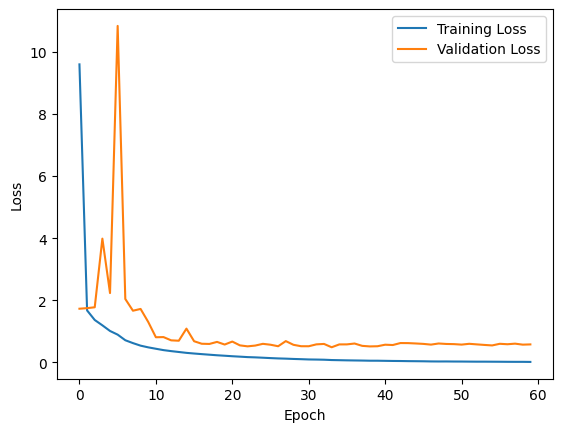

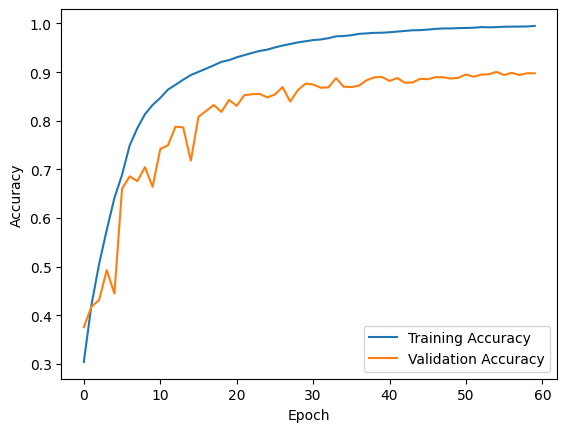

In [12]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt


# Define function to train one epoch of the model

def train_epoch(custom_model, dataloader, criterion, optimizer, device):
    custom_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
      # Loop over batches in the dataloader

    for i, data in enumerate(dataloader, 0):
        # Get inputs and labels from batch and move them to the device (GPU or CPU)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients of the optimizer

        optimizer.zero_grad()
 # Pass inputs through the model and calculate loss
        outputs = custom_model(inputs)
        loss = criterion(outputs, labels)
          # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Keep track of the running loss
        running_loss += loss.item()
 # Get the predicted labels and calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 # Calculate average epoch loss and accuracy
    epoch_loss = running_loss / (i + 1)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc
# Define function to validate the model on one epoch of data
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
 # Disable gradient calculation during validation
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 # epoch loss and accuracy
    epoch_loss = running_loss / (i + 1)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Training parameters
num_epochs = 60
print_every = 5

# Store the loss and accuracy history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(custom_model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(custom_model, testloader, criterion, device)

    # Update the learning rate scheduler
    scheduler.step()

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Plot loss curves
plt.figure()
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The results show the performance of our model trained on the CIFAR -10  dataset over 60 epochs. The model's performance is measured in terms of training and validation loss and accuracy.

The training loss and accuracy indicate how well the model is performing on the training set, while the validation loss and accuracy show how well it can generalize to new, unseen data.

The results show that the model's performance improves as the number of epochs increases. Initially, the training loss and validation loss are high, and the accuracy is low. However, as the number of epochs increases, the training and validation loss decrease, and the accuracy increases.

The final accuracy obtained on the validation set is around 89%, indicating that the model is performing well on new, unseen data.